In [1]:
%matplotlib inline
from matplotlib import pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
import copy
import warnings
from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier, XGBRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,StratifiedKFold
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import MinMaxScaler
import math 
from math import log 
from datetime import datetime 
import matplotlib.pyplot as plt 
import seaborn as sns   
from mlxtend.frequent_patterns import apriori
from  mlxtend.frequent_patterns import association_rules 
warnings.filterwarnings("ignore")
warnings.simplefilter(action= 'ignore', category= FutureWarning)
pd.set_option('display.max_columns', 200)

In [2]:
train = pd.read_csv('../Data/house_price_data.csv')
train.head()

Unnamed: 0                                          title  \
0           0        3 bedroom apartment for sale in Clifton   
1           1   7 bedroom house for sale in Constantia Upper   
2           2         3 bedroom house for sale in Bantry Bay   
3           3           5 bedroom house for sale in Fresnaye   
4           4     3 bedroom apartment for sale in Bantry Bay   

                                    priceDescription  propertyType  suburb  \
0  \r\n                                          ...           NaN     NaN   
1  \r\n                                          ...           NaN     NaN   
2  \r\n                                          ...           NaN     NaN   
3  \r\n                                          ...           NaN     NaN   
4  \r\n                                          ...           NaN     NaN   

   bedroom  bathroom  garage  parking   erfSize buildingSize  
0        3       3.0       0        0         0       310 m²  
1        7       7.0       3        0  7,555 m²            0  
2        3       3.5       2        0    626 m²            0  
3        5       5.0       4        4  1,044 m²       900 m²  
4        3       3.0       2        0         0       546 m²

# Data cleaning 

In [3]:
def clean_data(db):
    #create new ID for each houses
    db['ID'] = db.index+1
    db['ID'] = "H_" + db['ID'].astype(str)
    #get the price
    db['price']=db['priceDescription'].str.strip()
    db = db.drop(['priceDescription'],axis=1)
    #get the suburb
    db['suburb'] = db['title'].str.split("in",expand=True)[1]
    #get the property type
    db['propertyType'] = db['title'].str.split("in",expand=True)[0]
    type_p = []
    property_type = db['propertyType'].tolist()
    for i in range(len(property_type)):
        temp = property_type[i].split(sep="for sale")
        type_p.append(temp[0].strip().split(sep=" ")[-1])
    db['propertyType'] = type_p
    
    db = db.replace(to_replace =',', value = '', regex = True)
    db = db.replace(to_replace =' m²', value = '', regex = True)
    db = db.replace(to_replace ='R', value = '', regex = True)
    db['price'] = db['price'].replace(to_replace="POA", value =np.NaN, regex = True)
    #change string into numeric value
    db['erfSize'] = db['erfSize'].apply(pd.to_numeric)
    db['buildingSize'] = db['buildingSize'].apply(pd.to_numeric)
    db['price'] = db['price'].apply(pd.to_numeric)
    
    features = ['erfSize','buildingSize'] 
    for f in features:
        db.loc[(db[f] == 0),f]=np.NaN
    
    db = db.drop(["title"], axis=1)
    
    return db 
train = clean_data(train)
train.head()

Unnamed: 0 propertyType             suburb  bedroom  bathroom  garage  \
0           0    apartment            Clifton        3       3.0       0   
1           1        house   Constantia Upper        7       7.0       3   
2           2        house         Bantry Bay        3       3.5       2   
3           3        house           Fresnaye        5       5.0       4   
4           4    apartment         Bantry Bay        3       3.0       2   

   parking  erfSize  buildingSize   ID       price  
0        0      NaN         310.0  H_1  49990000.0  
1        0   7555.0           NaN  H_2  49000000.0  
2        0    626.0           NaN  H_3  49000000.0  
3        4   1044.0         900.0  H_4  47500000.0  
4        0      NaN         546.0  H_5  45000000.0

Deal with missing values

In [5]:
#Deal with misisng values
missing = ["erfSize", "buildingSize"]
for m in missing:
    train[m]= train[m].fillna(train[m].median())
#One hot enc
train = pd.get_dummies(train, columns=["propertyType"])
train.head()

Unnamed: 0             suburb  bedroom  bathroom  garage  parking  erfSize  \
0           0            Clifton        3       3.0       0        0    715.0   
1           1   Constantia Upper        7       7.0       3        0   7555.0   
2           2         Bantry Bay        3       3.5       2        0    626.0   
3           3           Fresnaye        5       5.0       4        4   1044.0   
4           4         Bantry Bay        3       3.0       2        0    715.0   

   buildingSize   ID       price  propertyType_Apartment  \
0         310.0  H_1  49990000.0                       0   
1         145.0  H_2  49000000.0                       0   
2         145.0  H_3  49000000.0                       0   
3         900.0  H_4  47500000.0                       0   
4         546.0  H_5  45000000.0                       0   

   propertyType_Guesthouse  propertyType_House  propertyType_Park  \
0                        0                   0                  0   
1                        0                   0                  0   
2                        0                   0                  0   
3                        0                   0                  0   
4                        0                   0                  0   

   propertyType_apartment  propertyType_auction  propertyType_breakfast  \
0                       1                     0                       0   
1                       0                     0                       0   
2                       0                     0                       0   
3                       0                     0                       0   
4                       1                     0                       0   

   propertyType_bus  propertyType_cottage  propertyType_farm  \
0                 0                     0                  0   
1                 0                     0                  0   
2                 0                     0                  0   
3                 0                     0                  0   
4                 0                     0                  0   

   propertyType_flats  propertyType_guesthouse  propertyType_home  \
0                   0                        0                  0   
1                   0                        0                  0   
2                   0                        0                  0   
3                   0                        0                  0   
4                   0                        0                  0   

   propertyType_house  propertyType_land  propertyType_loft  \
0                   0                  0                  0   
1                   1                  0                  0   
2                   1                  0                  0   
3                   1                  0                  0   
4                   0                  0                  0   

   propertyType_office  propertyType_property  propertyType_townhouse  
0                    0                      0                       0  
1                    0                      0                       0  
2                    0                      0                       0  
3                    0                      0                       0  
4                    0                      0                       0

In [6]:
train.head()

Unnamed: 0             suburb  bedroom  bathroom  garage  parking  erfSize  \
0           0            Clifton        3       3.0       0        0    715.0   
1           1   Constantia Upper        7       7.0       3        0   7555.0   
2           2         Bantry Bay        3       3.5       2        0    626.0   
3           3           Fresnaye        5       5.0       4        4   1044.0   
4           4         Bantry Bay        3       3.0       2        0    715.0   

   buildingSize   ID       price  propertyType_Apartment  \
0         310.0  H_1  49990000.0                       0   
1         145.0  H_2  49000000.0                       0   
2         145.0  H_3  49000000.0                       0   
3         900.0  H_4  47500000.0                       0   
4         546.0  H_5  45000000.0                       0   

   propertyType_Guesthouse  propertyType_House  propertyType_Park  \
0                        0                   0                  0   
1                        0                   0                  0   
2                        0                   0                  0   
3                        0                   0                  0   
4                        0                   0                  0   

   propertyType_apartment  propertyType_auction  propertyType_breakfast  \
0                       1                     0                       0   
1                       0                     0                       0   
2                       0                     0                       0   
3                       0                     0                       0   
4                       1                     0                       0   

   propertyType_bus  propertyType_cottage  propertyType_farm  \
0                 0                     0                  0   
1                 0                     0                  0   
2                 0                     0                  0   
3                 0                     0                  0   
4                 0                     0                  0   

   propertyType_flats  propertyType_guesthouse  propertyType_home  \
0                   0                        0                  0   
1                   0                        0                  0   
2                   0                        0                  0   
3                   0                        0                  0   
4                   0                        0                  0   

   propertyType_house  propertyType_land  propertyType_loft  \
0                   0                  0                  0   
1                   1                  0                  0   
2                   1                  0                  0   
3                   1                  0                  0   
4                   0                  0                  0   

   propertyType_office  propertyType_property  propertyType_townhouse  
0                    0                      0                       0  
1                    0                      0                       0  
2                    0                      0                       0  
3                    0                      0                       0  
4                    0                      0                       0

# EDA

# Correlation matrix 

In [7]:
train_new = train.copy()
corr = train_new.drop(['ID'],axis=1).corr()
corr.style.background_gradient(cmap='viridis').set_precision(2)

Here we can conclude that most of the features are indepedent 

In [8]:
corr_feat = ['price','bedroom','bathroom','garage','parking','erfSize','buildingSize']
train_new = train[corr_feat]
corr = train_new.corr()
corr.style.background_gradient(cmap='viridis').set_precision(2)

Here we can observe that the correlation coefficients between the price and the parking number are significants 

# Pairplot

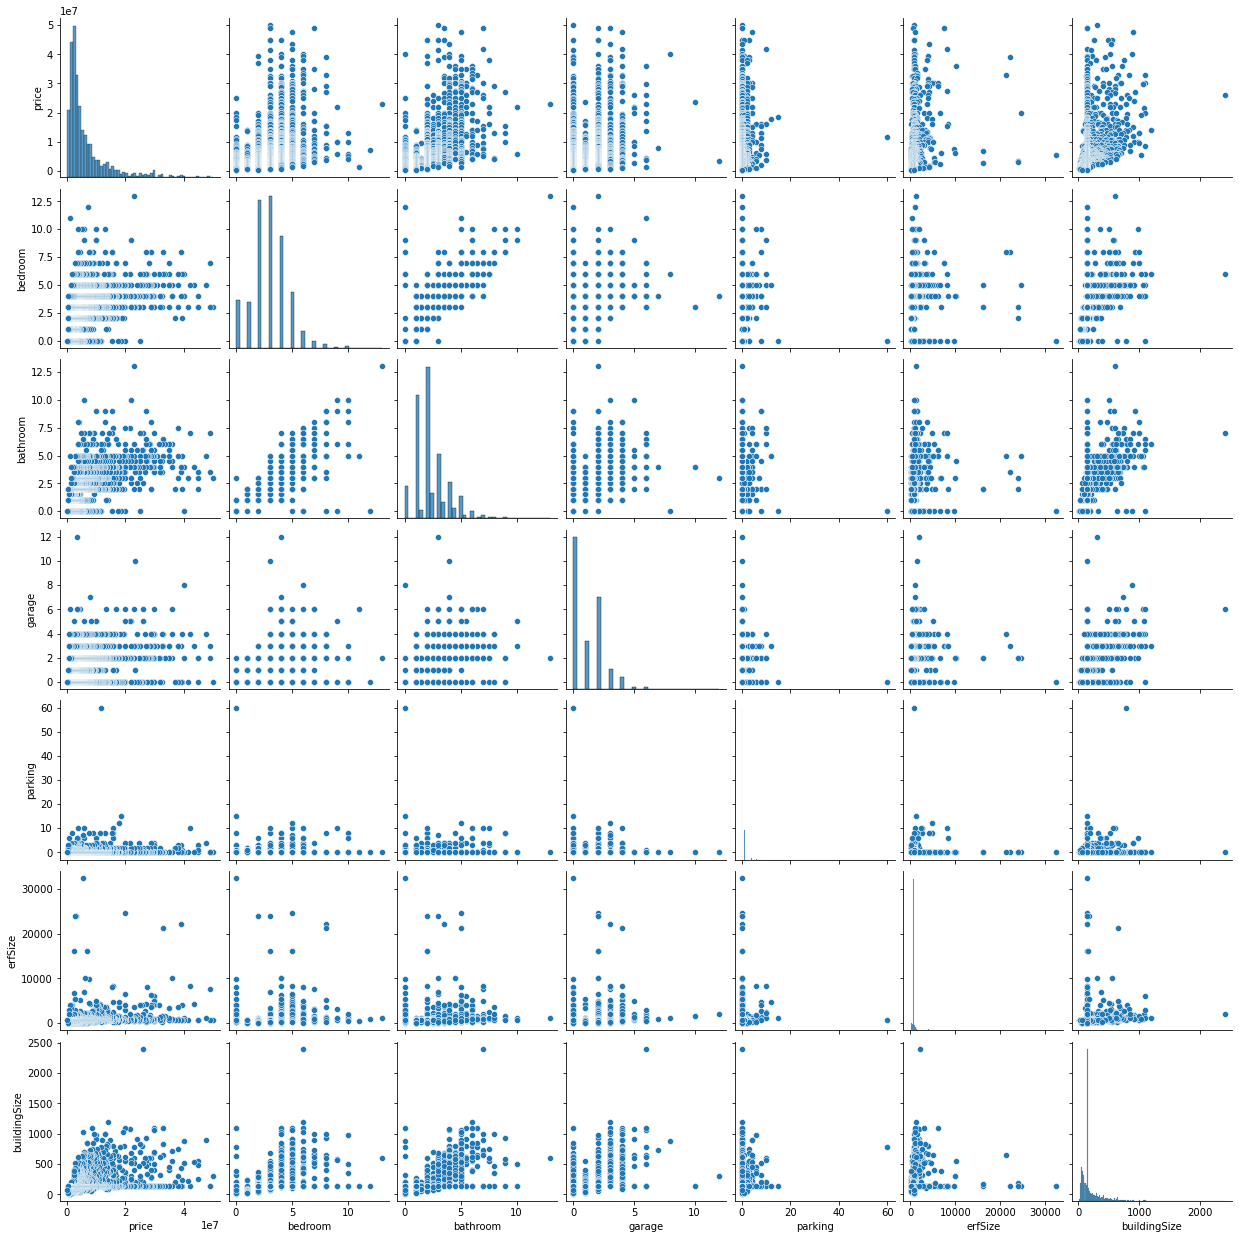

In [9]:
sns.pairplot(data=train[['price', 'bedroom', 'bathroom', 'garage', 'parking','erfSize','buildingSize']])

In [10]:
from pandas_profiling import ProfileReport
report = ProfileReport(train)
report.to_file(output_file="House_price_EDA.html")

In [11]:
report

In [13]:
# Remove Nan From Target
train = train[pd.notnull(train['price'])] 
#Winsorizing  (Warning)
train['price'] = train['price'].apply(lambda x: x if x <= train['price'].quantile(.8) else train['price'].quantile(.8))

In [14]:
train.head()

Unnamed: 0             suburb  bedroom  bathroom  garage  parking  erfSize  \
0           0            Clifton        3       3.0       0        0    715.0   
1           1   Constantia Upper        7       7.0       3        0   7555.0   
2           2         Bantry Bay        3       3.5       2        0    626.0   
3           3           Fresnaye        5       5.0       4        4   1044.0   
4           4         Bantry Bay        3       3.0       2        0    715.0   

   buildingSize   ID      price  propertyType_Apartment  \
0         310.0  H_1  9500000.0                       0   
1         145.0  H_2  9500000.0                       0   
2         145.0  H_3  9500000.0                       0   
3         900.0  H_4  9500000.0                       0   
4         546.0  H_5  9500000.0                       0   

   propertyType_Guesthouse  propertyType_House  propertyType_Park  \
0                        0                   0                  0   
1                        0                   0                  0   
2                        0                   0                  0   
3                        0                   0                  0   
4                        0                   0                  0   

   propertyType_apartment  propertyType_auction  propertyType_breakfast  \
0                       1                     0                       0   
1                       0                     0                       0   
2                       0                     0                       0   
3                       0                     0                       0   
4                       1                     0                       0   

   propertyType_bus  propertyType_cottage  propertyType_farm  \
0                 0                     0                  0   
1                 0                     0                  0   
2                 0                     0                  0   
3                 0                     0                  0   
4                 0                     0                  0   

   propertyType_flats  propertyType_guesthouse  propertyType_home  \
0                   0                        0                  0   
1                   0                        0                  0   
2                   0                        0                  0   
3                   0                        0                  0   
4                   0                        0                  0   

   propertyType_house  propertyType_land  propertyType_loft  \
0                   0                  0                  0   
1                   1                  0                  0   
2                   1                  0                  0   
3                   1                  0                  0   
4                   0                  0                  0   

   propertyType_office  propertyType_property  propertyType_townhouse  
0                    0                      0                       0  
1                    0                      0                       0  
2                    0                      0                       0  
3                    0                      0                       0  
4                    0                      0                       0

# Dealing with outliers

Data visualization

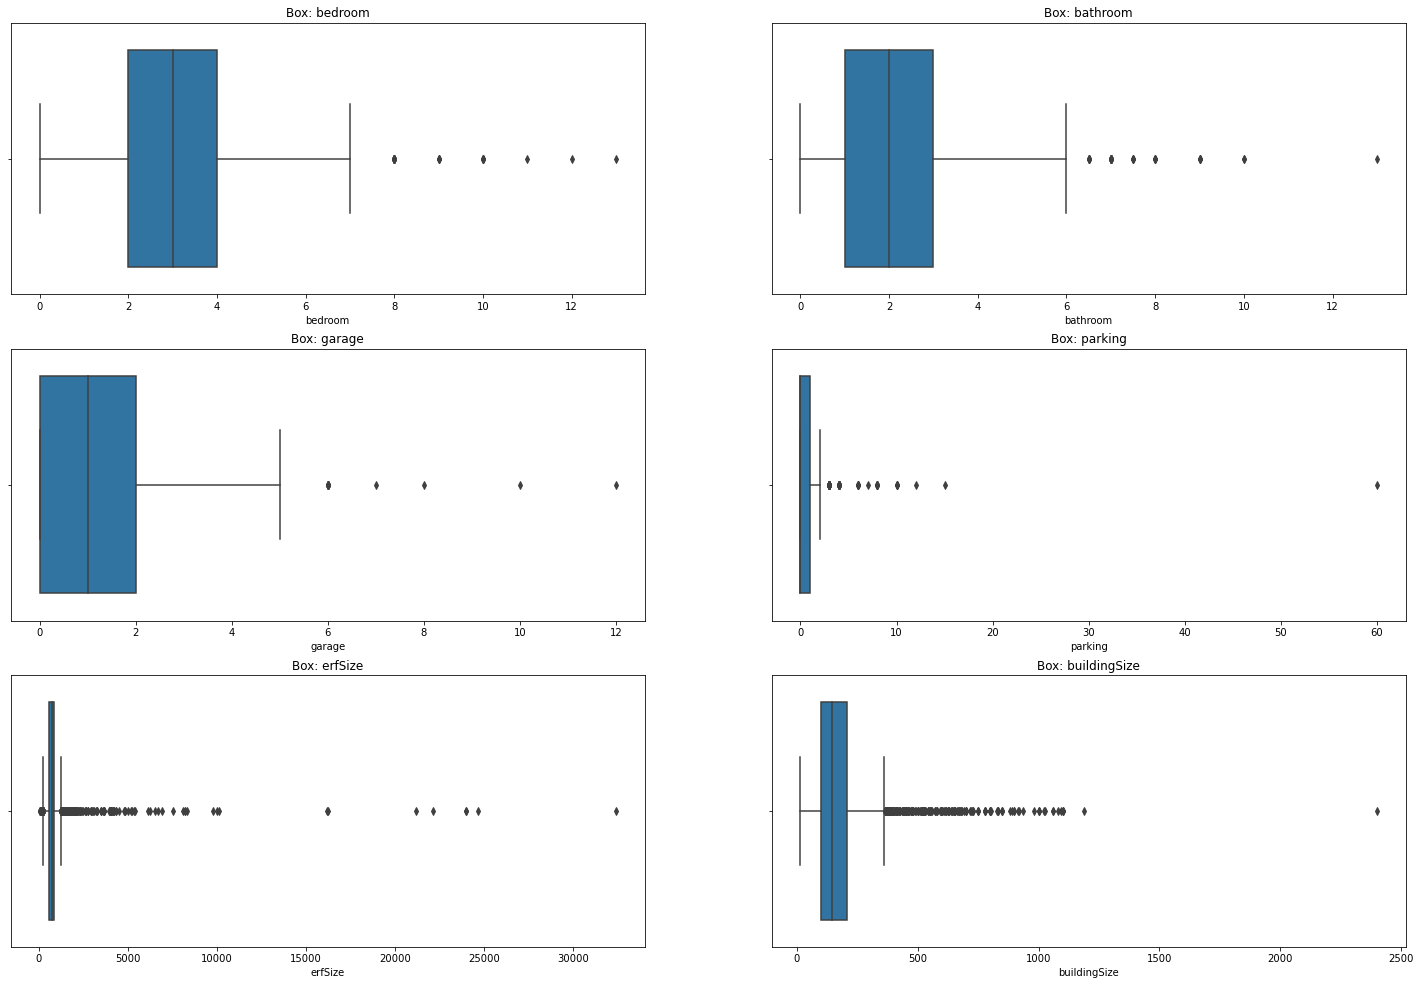

In [15]:
col = ['bedroom', 'bathroom', 'garage', 'parking','erfSize','buildingSize']
fig = plt.figure()
fig.set_size_inches(25, 35)
x = 1
ax = []
for c in col:
    ax.append(fig.add_subplot(6, 2, x))
    ax[-1].set_title('Box: ' + c)
    sns.boxplot(x=train[c], ax=ax[-1])
    x += 1 
fig.show()

In [16]:
from pyod.models.iforest import IForest 
#outlier prediction 
def predict_outlier(db,feat):
    db_clean=  db[[feat]]
    clf = IForest() #KNN()
    clf.fit(db_clean)
    db['is_outlier'] = clf.predict(db_clean)
    mask = db['is_outlier'] == 1
    db.loc[mask, feat] = db[feat].median()
    return db   


In [17]:
for c in col:
    train = predict_outlier(train,c)

In [18]:
train = train.drop(['is_outlier'],axis=1)
train.head()

Unnamed: 0             suburb  bedroom  bathroom  garage  parking  erfSize  \
0           0            Clifton      3.0       3.0     0.0      0.0    715.0   
1           1   Constantia Upper      3.0       2.0     3.0      0.0    715.0   
2           2         Bantry Bay      3.0       3.5     2.0      0.0    626.0   
3           3           Fresnaye      5.0       5.0     1.0      0.0   1044.0   
4           4         Bantry Bay      3.0       3.0     2.0      0.0    715.0   

   buildingSize   ID      price  propertyType_Apartment  \
0         310.0  H_1  9500000.0                       0   
1         145.0  H_2  9500000.0                       0   
2         145.0  H_3  9500000.0                       0   
3         145.0  H_4  9500000.0                       0   
4         145.0  H_5  9500000.0                       0   

   propertyType_Guesthouse  propertyType_House  propertyType_Park  \
0                        0                   0                  0   
1                        0                   0                  0   
2                        0                   0                  0   
3                        0                   0                  0   
4                        0                   0                  0   

   propertyType_apartment  propertyType_auction  propertyType_breakfast  \
0                       1                     0                       0   
1                       0                     0                       0   
2                       0                     0                       0   
3                       0                     0                       0   
4                       1                     0                       0   

   propertyType_bus  propertyType_cottage  propertyType_farm  \
0                 0                     0                  0   
1                 0                     0                  0   
2                 0                     0                  0   
3                 0                     0                  0   
4                 0                     0                  0   

   propertyType_flats  propertyType_guesthouse  propertyType_home  \
0                   0                        0                  0   
1                   0                        0                  0   
2                   0                        0                  0   
3                   0                        0                  0   
4                   0                        0                  0   

   propertyType_house  propertyType_land  propertyType_loft  \
0                   0                  0                  0   
1                   1                  0                  0   
2                   1                  0                  0   
3                   1                  0                  0   
4                   0                  0                  0   

   propertyType_office  propertyType_property  propertyType_townhouse  
0                    0                      0                       0  
1                    0                      0                       0  
2                    0                      0                       0  
3                    0                      0                       0  
4                    0                      0                       0

# Model Training 

Mean absolute percentage error (MAPE)

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Parameters

In [20]:
params = { "n_estimators": 100, "max_depth":-1, "num_leaves":32, 'learning_rate': 0.001,"min_child_samples": 20,
                  'feature_fraction': 0.8,"bagging_freq":1,'bagging_fraction': 0.9,"lambda_l1":1,"lambda_l2":1, "random_state":47}

In [21]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [24]:
DROP = ['price', 'ID','Unnamed0','suburb']
FEATURES = train.columns.drop(DROP)
print(FEATURES)

Index(['bedroom', 'bathroom', 'garage', 'parking', 'erfSize', 'buildingSize',
       'propertyType_Apartment', 'propertyType_Guesthouse',
       'propertyType_House', 'propertyType_Park', 'propertyType_apartment',
       'propertyType_auction', 'propertyType_breakfast', 'propertyType_bus',
       'propertyType_cottage', 'propertyType_farm', 'propertyType_flats',
       'propertyType_guesthouse', 'propertyType_home', 'propertyType_house',
       'propertyType_land', 'propertyType_loft', 'propertyType_office',
       'propertyType_property', 'propertyType_townhouse'],
      dtype='object')


In [23]:
train.head()

Unnamed0             suburb  bedroom  bathroom  garage  parking  erfSize  \
0         0            Clifton      3.0       3.0     0.0      0.0    715.0   
1         1   Constantia Upper      3.0       2.0     3.0      0.0    715.0   
2         2         Bantry Bay      3.0       3.5     2.0      0.0    626.0   
3         3           Fresnaye      5.0       5.0     1.0      0.0   1044.0   
4         4         Bantry Bay      3.0       3.0     2.0      0.0    715.0   

   buildingSize   ID      price  propertyType_Apartment  \
0         310.0  H_1  9500000.0                       0   
1         145.0  H_2  9500000.0                       0   
2         145.0  H_3  9500000.0                       0   
3         145.0  H_4  9500000.0                       0   
4         145.0  H_5  9500000.0                       0   

   propertyType_Guesthouse  propertyType_House  propertyType_Park  \
0                        0                   0                  0   
1                        0                   0                  0   
2                        0                   0                  0   
3                        0                   0                  0   
4                        0                   0                  0   

   propertyType_apartment  propertyType_auction  propertyType_breakfast  \
0                       1                     0                       0   
1                       0                     0                       0   
2                       0                     0                       0   
3                       0                     0                       0   
4                       1                     0                       0   

   propertyType_bus  propertyType_cottage  propertyType_farm  \
0                 0                     0                  0   
1                 0                     0                  0   
2                 0                     0                  0   
3                 0                     0                  0   
4                 0                     0                  0   

   propertyType_flats  propertyType_guesthouse  propertyType_home  \
0                   0                        0                  0   
1                   0                        0                  0   
2                   0                        0                  0   
3                   0                        0                  0   
4                   0                        0                  0   

   propertyType_house  propertyType_land  propertyType_loft  \
0                   0                  0                  0   
1                   1                  0                  0   
2                   1                  0                  0   
3                   1                  0                  0   
4                   0                  0                  0   

   propertyType_office  propertyType_property  propertyType_townhouse  
0                    0                      0                       0  
1                    0                      0                       0  
2                    0                      0                       0  
3                    0                      0                       0  
4                    0                      0                       0

Cross Validation 

In [25]:
epochs = 5 
kf = KFold(n_splits=epochs, shuffle=True, random_state=30) #30 #Stratified is best for classificaion 
X_train = train[FEATURES]
y_train = train[['price']] 
i = 0
metrics = list()
#split using  KFold
for tr_idx, val_idx in kf.split(X_train, y_train):
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx] 
    model = LGBMRegressor(**params)
    model.fit(X_tr, y_tr) 
    y_pred = model.predict(X_vl)
    #y_pred = y_pred.reshape(-1, 1)
    mape = mean_absolute_percentage_error(y_pred,y_vl)
    print("mape  Fold # " + str(i+1) + ": " + str(mape))
    i += 1
    metrics.append(mape)
metrics = np.array(metrics).mean()
print("Global Metrics: {}".format(metrics))

mape  Fold # 1: 55.87043676329358
mape  Fold # 2: 54.607723714397835
mape  Fold # 3: 54.84690988029685
mape  Fold # 4: 58.79623680039234
mape  Fold # 5: 54.4566335340392
Global Metrics: 55.715588138483966
